In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Value or parameter: We can call it scaler
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

In [4]:
xs = np.arange(-5, 5, .25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

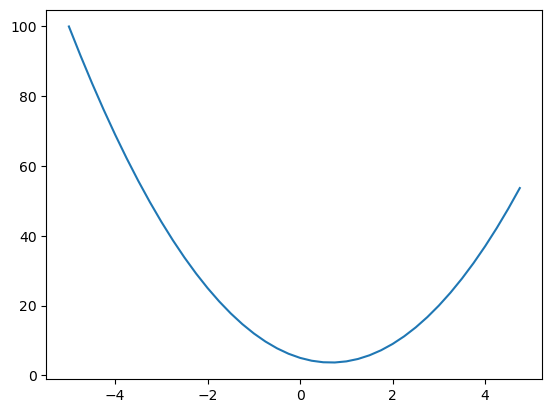

In [6]:
plt.plot(xs, ys)

# Experiment with derivative

In [7]:
# Intuitively understand what derivative tells us

h = 0.001
x = 3.0
print(f(x+h))
print(f(x+h) - f(x))
print((f(x+h) - f(x)) / h)

print()

h = 0.001
x = -3.0
print(f(x+h))
print(f(x+h) - f(x))
print((f(x+h) - f(x)) / h)

20.014003000000002
0.01400300000000243
14.00300000000243

43.978003
-0.021996999999998934
-21.996999999998934


In [8]:
# Let's get more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

# derivative of d with respect to a: What's the influence of scaler a on output d?
d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

print()

# derivative of d with respect to b
d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

# derivative of d with respect to c
d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772

d1 3.999699999999999
d2 3.99990001
slope 2.0001000000124947
d1 3.99990001
d2 4.00000001
slope 0.9999999999976694


# Class Value

In [75]:
"""
In Python, when you use the + operator to add two objects, the __add__ method is called on the left operand (the object before the +). 

If the left operand does not implement __add__ or that method returns NotImplemented, Python tries to call the __radd__ method
    on the right operand (the object after the +) as a fallback.
"""

from typing import Union

class Value:

    def __init__(self, data: int, _children=(), _op='', label='') -> None:
        self.data = data
        self.label = label
        
        # gradient / derivative of L with respect to this value
        # 0 means no effect
        self.grad = 0 

        # To keep track of the two operands for this value so we can perform backpropagation
        self._prev = set(_children)
        
        # To keep track of the operator that creates this value
        self._op = _op

        # Use to automate backpropagation
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: Union["Value", int, float]) -> "Value":
        # Handle numerical
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            """
            out = x + y
            => d(out)/dx = 1.0
                d(out)/dy = 1.0

            d(final) / dx = (d(final) / d(out)) * (d(out) / dx)
            ...
            ---
            FIX BUG: Do accumulate '+=' instead of just assign '=' to fix bugs mentioned far below with examples
            """
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __radd__(self, other: Union["Value", int, float]) -> "Value": # other + self (fallback in case other is integer)
        return self + other
    
    def __neg__(self) -> "Value": # -self
        return self * -1
    
    def __sub__(self, other: Union["Value", int , float]) -> "Value": # self - other
        return self + (-other)
    
    def __mul__(self, other: Union["Value", int, float]) -> "Value":
        # Handle numerical
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            """
            out = x * y
            => d(out)/dx = y
                d(out)/dy = x

            d(final) / dx = (d(final) / d(out)) * (d(out) / dx)
            ---
            FIX BUG: Do accumulate '+=' instead of just assign '=' to fix bugs mentioned far below with examples
            """
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other: Union["Value", int, float]) -> "Value": # other * self (fallback in case other is integer)
        return self * other
    
    def __truediv__(self, other: Union["Value", int, float]) -> "Value": # self / other
        return self * other**-1
    
    def __pow__(self, other: int | float) -> "Value": # self^other (self ** other)
        assert isinstance(other, (int, float)) # Only support power of int or float now
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            """
            out = x^c (with c is a constant)
            => d(out)/dx = c * x^(c-1)

            d(final) / dx = (d(final) / d(out)) * (d(out) / dx)
            ---
            FIX BUG: Do accumulate '+=' instead of just assign '=' to fix bugs mentioned far below with examples
            """
            self.grad += other * (self.data ** (other-1)) * out.grad

        out._backward = _backward
        return out
    
    def tanh(self) -> "Value":
        """
        We don't need to implement the most atomic operations like exponential e^x, or divide, ...
        We can implement directly a complex function like tanh(x) as long as we can calculate the derivative of the whole thing
        So that we can backpropagate through it
        """
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            """
            out = tanh(x)
            => d(out)/dx = 1 - tanh(x)^2 = 1 - out^2

            d(final) / dx = (d(final) / d(out)) * (d(out) / dx)
            ---
            FIX BUG: Do accumulate '+=' instead of just assign '=' to fix bugs mentioned far below with examples
            """
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self) -> "Value": # e^self
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            """
            out = e^x
            => d(out)/dx = e^x = out !!!

            d(final) / dx = (d(final) / d(out)) * (d(out) / dx)
            ---
            FIX BUG: Do accumulate '+=' instead of just assign '=' to fix bugs mentioned far below with examples
            """
            self.grad += math.exp(x) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        # Topological sorting with parent at the end
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                
                # Push all recursive children first
                for child in v._prev:
                    build_topo(child)

                # Push parent final
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0 # Base case derivative for final output node
        for node in reversed(topo):
            node._backward()
    
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'

# a.__add__(b)
print(a + b)
print(a * b)

# (a.__mul__(b)).__add__(c)
d = e + c; d.label = 'd'
print(d)
print(d._prev)
print(d._op)

f = Value(-2.0, label='f')

L = d * f; L.label = 'L'
L

Value(data=-1.0)
Value(data=-6.0)
Value(data=4.0)
{Value(data=10.0), Value(data=-6.0)}
+


Value(data=-8.0)

In [11]:
from graphviz import Digraph

def trace(root):
    # builds set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any node in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = '{ %s | data %.4f | grad %.4f }' % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this op node to the value node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to op node of n2
        dot.edge(str(id(n1)), str((id(n2))) + n2._op)

    return dot

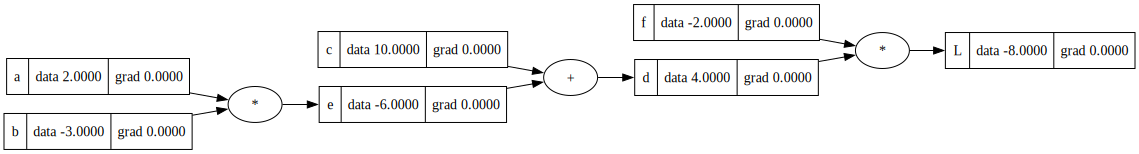

In [12]:
# So far, we have done a forward pass to get the final output L
draw_dot(L)

# Manual backpropagation example

In [13]:
# NOW, we will start to backpropagate manually the gradient (derivative of output node with respect to each node) 
# starting from the output back to the start

# L = d * f
# dL/dd = ? -> f
 
"""
(f(x+h) - f(x)) / h

With respect to d:
    ((d+h)*f - (d*f)) / h
    = f
"""

'\n(f(x+h) - f(x)) / h\n\nWith respect to d:\n    ((d+h)*f - (d*f)) / h\n    = f\n'

In [14]:
L.grad = 1.0 # Base case since changing L will affect L itself linearly

f.grad = 4.0 # dL/df = d = 4.0
d.grad = -2.0 # dL/dd = f = -2.0

In [15]:
# dL/dc = ?
# We know c affect L through d, so we will do some chain rule here

"""
d = c + e
=> dd / dc = 1
    dd / de = 1

We can call this as 'local derivative', what we want is to know how a node affects the last output (and not just the local area around itself)

WANT:
Using chain rule
-> dL / dc = (dL / dd) * (dd / dc)

KNOW:
dL / dd
dd / dc
"""

"\nd = c + e\n=> dd / dc = 1\n    dd / de = 1\n\nWe can call this as 'local derivative', what we want is to know how a node affects the last output (and not just the local area around itself)\n\nWANT:\nUsing chain rule\n-> dL / dc = (dL / dd) * (dd / dc)\n\nKNOW:\ndL / dd\ndd / dc\n"

In [16]:
c.grad = d.grad * 1.0 # -2.0
e.grad = d.grad * 1.0 # -2.0

In [17]:
"""
dL / de = -2

e = a * b
=> de / da = b
    de / db = a

dL / da = (dL / de) * (de / da) = -2b
dL / db = (dL / de) * (de / db) = -2a
"""

'\ndL / de = -2\n\ne = a * b\n=> de / da = b\n    de / db = a\n\ndL / da = (dL / de) * (de / da) = -2b\ndL / db = (dL / de) * (de / db) = -2a\n'

In [18]:
a.grad = e.grad * b.data # 6.0
b.grad = e.grad * a.data # -4.0

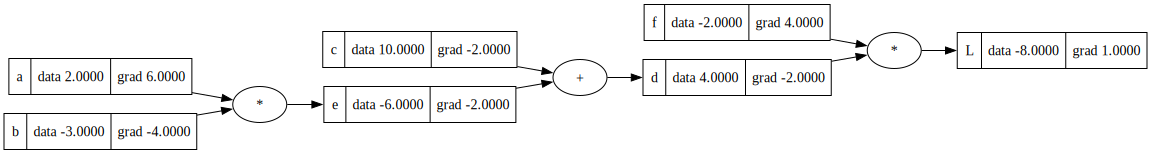

In [19]:
draw_dot(L)

In [20]:
# Example: Manually estimate gradient / derivative of L with respect to a
def lol():

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

6.000000000021544


In [21]:
"""
Try out the gradient, we will now nudge each variable in the same direction (positive or negative) of their gradients
Then, L will increase!

Take an example: 

dL/dx = -2 => L ~ -2x
- So if x goes in the direction of gradient (negative), x decreases, that means L will increase

dL/dx = 2 => L ~ 2x
- So if x goes in the direction of gradient (positive), x increases, that means L will increase
"""

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

# Expect L to be less negative
print(L.data)

-7.286496


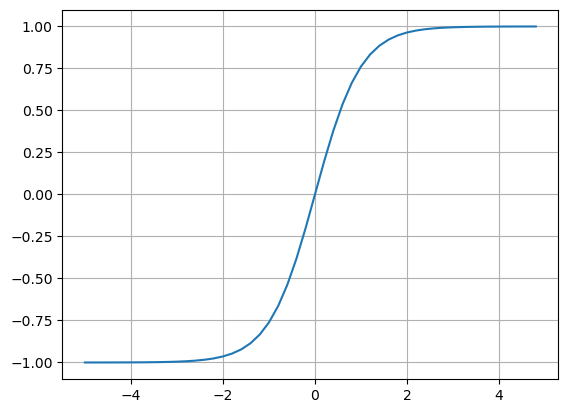

In [23]:
# Activation function: tanh()
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

# Neuron propagation example
[Refer to image of a neuron](./Neuron.png)

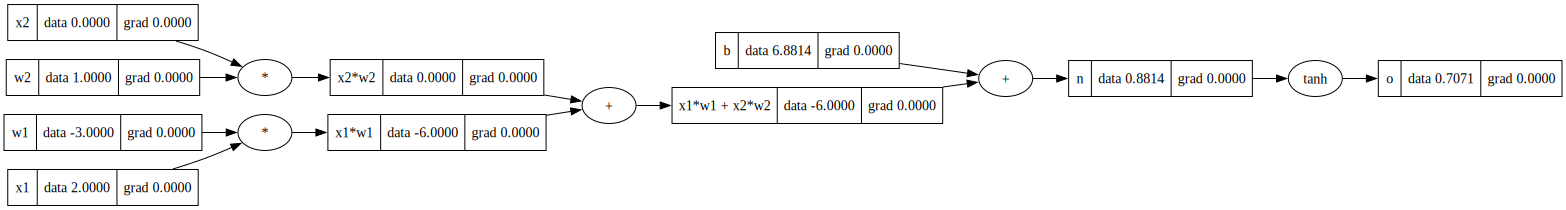

In [27]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [28]:
# Calculate gradient for each node in the computational graph here
o.grad = 1 # Base case = do/do = 1

In [29]:
"""
o = tanh(n)
=> do/dn = 1 - tanh(n)^2 = 1 - o^2
"""
n.grad = 1 - o.data**2

In [30]:
"""
n = x1w1x2w2 + b
=> dn / d(x1w1x2w2) = 1
    dn / db = 1

do / db = (do / dn) * (dn / db)
do / d(x1w1x2w2) = (do / dn) * (dn / d(x1w1x2w2))
"""
b.grad = n.grad
x1w1x2w2.grad = n.grad

In [32]:
"""
x1w1x2w2 = x1w1 + x2w2
=> ...

With plus operator, the gradients of children are the same as parent's
"""
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [33]:
"""
x2w2 = x2 * w2
=> d(x2w2) / d(x2) = w2
    d(x2w2) / d(w2) = x2

do/d(x2) = (do / d(x2w2)) * (d(x2w2) / d(x2))
...
"""
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [34]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

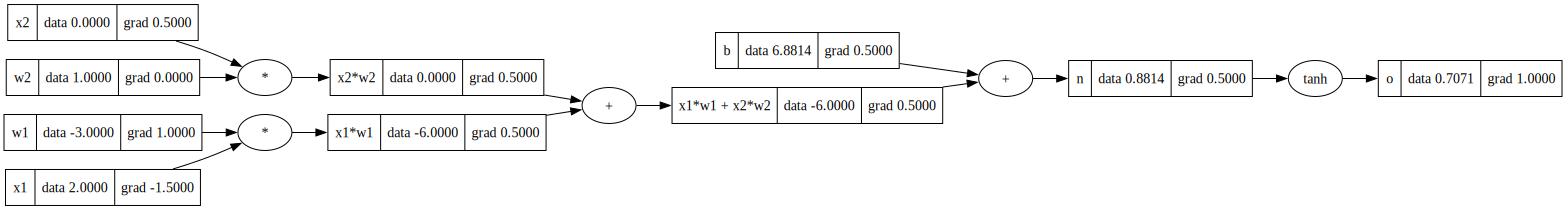

In [35]:
draw_dot(o)

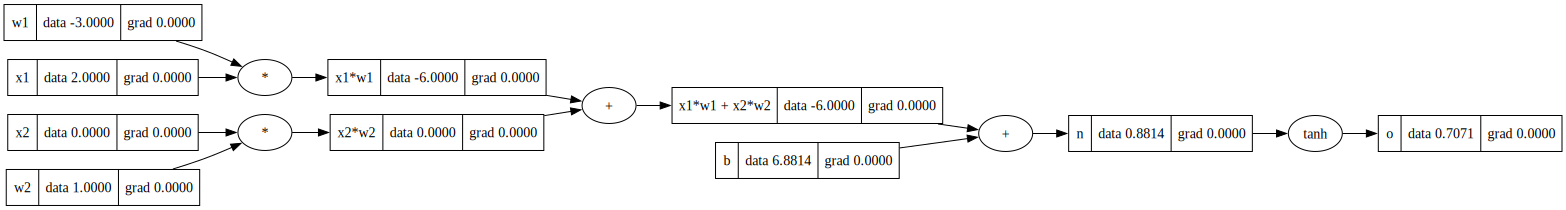

In [37]:
"""
Redo the gradients but with new _backward function we have just written
"""

# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

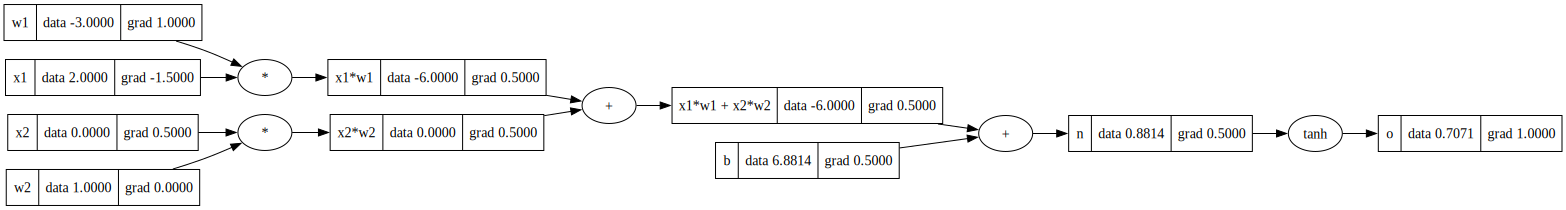

In [38]:
o.grad = 1.0 # Base case
o._backward() # Backpropagate o.grad through tanh to n
n._backward() # Backpropagate n.grad through + to b and x1w1x2w2
b._backward() # No children, so do nothing
x1w1x2w2._backward() # Backpropagate x1w1x2w2.grad through + to x1w1 and x2w2
x1w1._backward() # ...
x2w2._backward() # ...

draw_dot(o)

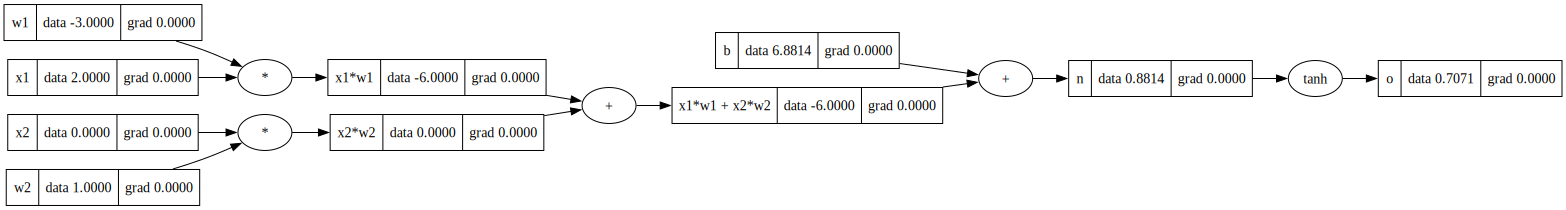

In [45]:
"""
Redo the gradients but with topological sorting and _backward function
"""

# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [46]:
# Topological order

topo = []
visited = set()

# Topological sorting with parent at the end
def build_topo(v):
    if v not in visited:
        visited.add(v)
        
        # Push all recursive children first
        for child in v._prev:
            build_topo(child)

        # Push parent final
        topo.append(v)

build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

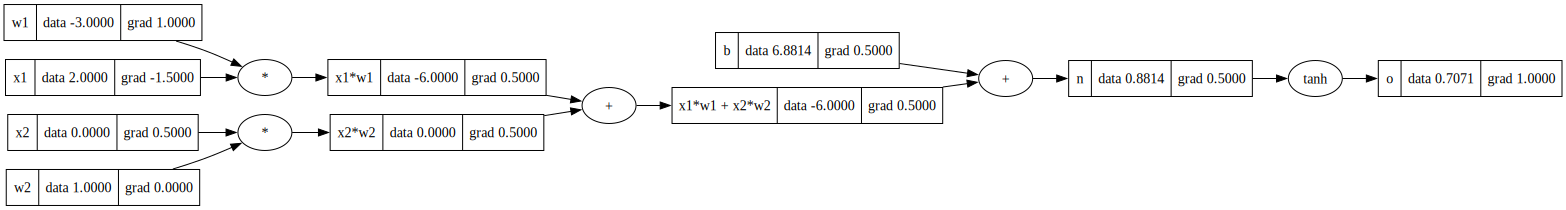

In [47]:
# Use _backward in reverse of topological list above

o.grad = 1.0 # Base case
for node in reversed(topo):
    node._backward()

draw_dot(o)

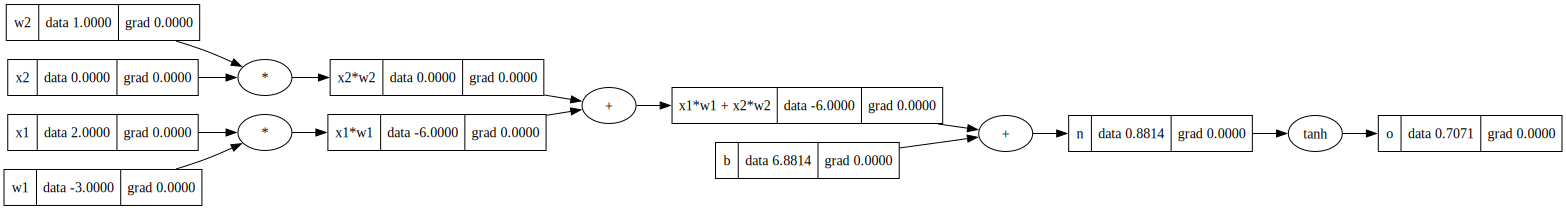

In [52]:
"""
Redo the gradients but with backward() function on the output node
"""

# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

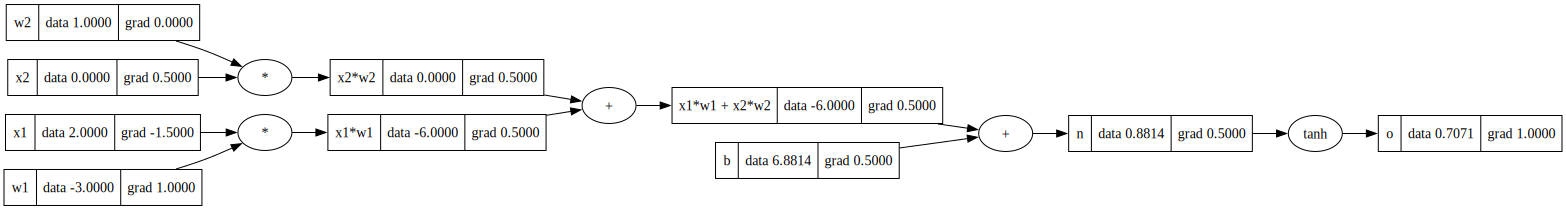

In [53]:
o.backward()
draw_dot(o)

# Fix bug for _backward in Value class

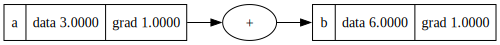

In [56]:
"""
Fix bug with our gradient backward function
"""

"""
Here, the gradient of a should be 2, but because of the logic in our _backward() in __add__ with assignment '=' instead of '+=',
we place 1 in self and other.
But self and other here are the same object lmao!
"""
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

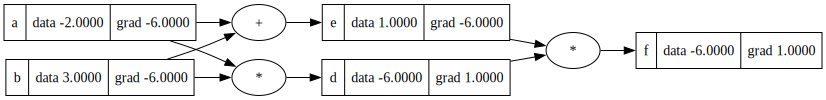

In [60]:
"""
Another example with bug.
Here a and b both have effect on e and d.
So our _backward() for __add__ and __mul__ are overriding each other for a and for b.
"""
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

In [61]:
"""
The solution is Multivariable case in Wikipedia.
Basically, the derivatives will accumulate.

=> df/da = df/de * de/da + df/dd * dd/da
"""

'\nThe solution is Multivariable case in Wikipedia.\nBasically, the derivatives will accumulate.\n\n=> df/da = df/de * de/da + df/dd * dd/da\n'

# Break down tanh() to practice more operations

In [63]:
"""
Now we will break down tanh formula instead of doing it in one single function.
This is a good exercise because we will need to implement exp (exponential), division, subtraction

We will also handle cases for numerical literal like:
a = Value(1.0)
b = a + 1

For division, a / b:
We can implement something even more powerful
    a / b = a * (1/b) = a * (b^-1)
-> So we can implement Value^k for any constant number k
"""

'\nNow we will break down tanh formula instead of doing it in one single function.\nThis is a good exercise because we will need to implement exp (exponential), division, subtraction\n\nWe will also handle cases for numerical literal like:\na = Value(1.0)\nb = a + 1\n'

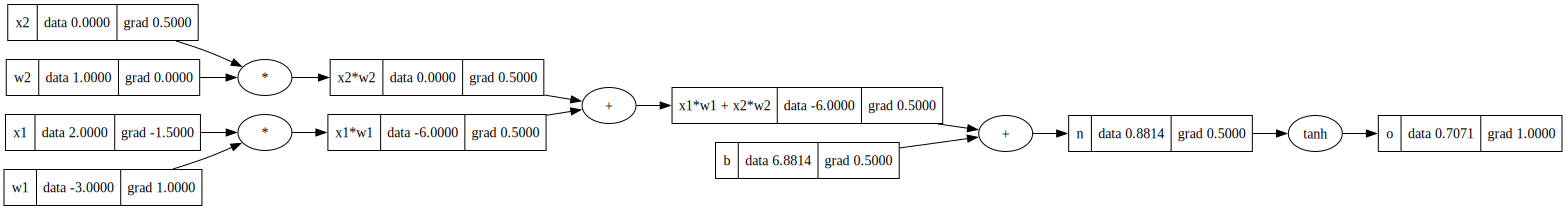

In [70]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

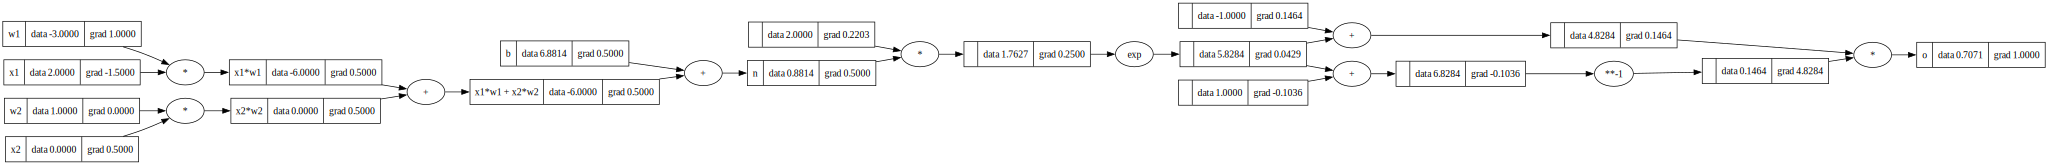

In [76]:
"""
Break down tanh
"""

# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

# ---
# tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)
e = (2*n).exp() # e^(2x)
o = (e - 1) / (e + 1)
o.label = 'o'
# ---

o.backward()
draw_dot(o)

# Use Pytorch and compare

In [77]:
import torch

"""
Tensor is just n-dimensional array of scalars
Tensor is basically a function of multi-dimensional array
A function here is transformation function
So Tensor can basically take in any multi-dimensional array and do transformations on them consistently
"""

"""
By default, leaf node doesn't need gradient, since input nodes in real life don't usually need gradient.
This is for effiency. Only internal weights and biases will have gradients.
"""

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

# .item() only used for one-element Tensor -> to extract that value and return in number
print(o.data.item()) # Print forward output

# Print backpropagation gradients on inputs and weights
print('---')
o.backward()
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [82]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [81]:
torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])

In [83]:
# By default, scalar in tensor in PyTorch has float32 type, single precision
# We cast that into 64 bits (double precision) above
# We want to cast it so it's consistent with Python system
torch.Tensor([2]).dtype

torch.float32

In [84]:
# o.item() and o.data.item() return same output here in PyTorch
o.item()

0.7071066904050358

# Build neural net
[Neural Net Image](./Neural_Net.png)

In [101]:
import random
from typing import List, Union

class Neuron:
    def __init__(self, n_inputs: int) -> None:
        """
        n_inputs: how many inputs coming into a neuron
        """
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x: List[Union["Value", int, float]]) -> "Value":
        """
        x: values coming into this neuron
        Goal: do forward calculation -> w * x + b

        __call__ allows to do sth like this:
        x = [1, 2, 3]
        obj = Neuron(3)
        obj(x) -> Directly call object as if it's a function
        """
        # zip will create a new iterator with tuples (pairs) from input arrays line up
        act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self) -> List["Value"]:
        """
        Return a list of all the parameters of this neuron
        """
        return self.w + [self.b]

class Layer:
    def __init__(self, n_inputs: int, n_outputs: int) -> None:
        """
        n_inputs: how many inputs each neuron in current layer connects
        n_outputs: how many neurons in current layer
        """
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]

    def __call__(self, x: List[Union["Value", int, float]]) -> Union[List["Value"], "Value"]:
        """
        x: values coming into this layer (these values are outputs of previous layer)
        Goal: return outputs of all neurons in current layer

        Since we are implementing a fully connected neural net, each neuron in current layer will use all values from previous layer.
        """
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self) -> List["Value"]:
        """
        Return a compiled list of all the parameters of all neurons in this layer
        """

        # One liner
        # return [p for neuron in self.neurons for p in neuron.parameters()]

        params: List["Value"] = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
    
class MLP:
    """
    MLP: Multi-layer perceptron, a modern feed forward artificial neural network
    """

    def __init__(self, n_inputs: int, outputs_list: List[int]) -> None:
        """
        n_inputs: how many inputs this neural net receives
        outputs_list: a list representing number of neurons in each layer
        """
        n_layers = len(outputs_list)
        sz = [n_inputs] + outputs_list
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(n_layers)]

    def __call__(self, x: List[Union["Value", int, float]]) -> Union[List["Value"], "Value"]:
        """
        Feed forward x into each layer and return outputs of the last layer
        """
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self) -> List["Value"]:
        """
        Return a compiled list of all the parameters of all layers in this neural net
        """
        return [p for layer in self.layers for p in layer.parameters()]

In [111]:
x = [2.0, 3.0, -1.0]
net = MLP(3, [4, 4, 1])
net(x)

Value(data=0.3886523191569329)

In [112]:
net.parameters()

[Value(data=0.1308683808804898),
 Value(data=-0.16224548596023491),
 Value(data=0.03301504165966662),
 Value(data=-0.28566118972491217),
 Value(data=0.2430202194388731),
 Value(data=0.14232987984282364),
 Value(data=-0.010025106514616855),
 Value(data=0.2714727834691606),
 Value(data=-0.03833888378112049),
 Value(data=-0.4840231520837359),
 Value(data=-0.872833356849184),
 Value(data=0.9907361202499485),
 Value(data=0.5428312213511877),
 Value(data=-0.1512612450711508),
 Value(data=0.810192277202552),
 Value(data=0.3267817968516604),
 Value(data=-0.017202112151344595),
 Value(data=0.5862453636233109),
 Value(data=-0.32728420889446763),
 Value(data=-0.17615998279107314),
 Value(data=-0.7416154972152293),
 Value(data=0.8095347894509284),
 Value(data=0.4774407994190397),
 Value(data=-0.7431172548962326),
 Value(data=0.5536680501379017),
 Value(data=0.8944078881797792),
 Value(data=-0.2934690806347273),
 Value(data=-0.9117633414863402),
 Value(data=-0.8817563459969677),
 Value(data=0.68516

In [113]:
len(net.parameters())

41

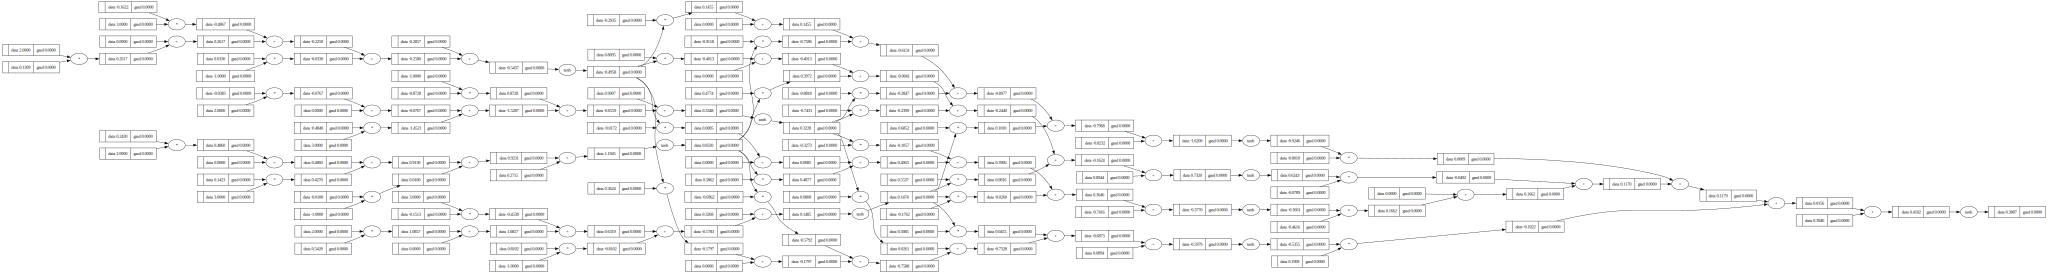

In [114]:
draw_dot(net(x))

# Create dataset and loss function

In [125]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # Desired targets
ypred = [net(x) for x in xs] # Feed each example into the neural net
ypred

[Value(data=0.3353133349345994),
 Value(data=0.4934531265235291),
 Value(data=0.39867589905032036),
 Value(data=0.48077226626429914)]

In [126]:
"""
To measure performance of a neural net, we have a single variable called 'loss'.
We want to minimize loss.
"""
# We will implement a simple sum square error here
loss: "Value" = sum((y_out - y_ground_truth)**2 for y_ground_truth, y_out in zip(ys, ypred))
loss

Value(data=4.898102313903202)

In [127]:
"""
MAGICAL step here!!!
Basically, we connect all the outputs and ground truth to the loss.
Now, with respect to loss, we will start backpropagate from there to fill in the gradients for all the outputs, weights, biases, ...
"""
loss.backward()

In [128]:
net.layers[0].neurons[0].w[0].grad

0.8125894256968387

In [129]:
# draw_dot(loss)

In [130]:
net.layers[0].neurons[0].w[0].data

0.126874627465335

In [131]:
"""
Nudge a tiny amount in the OPPOSITE direction of gradient.
Why?
Because as we have discovered somewhere above, if we make a variable go in the same direction of gradient, the final output will increase.
But the final output we are viewing here is the loss.
And we want to minimize the loss, not increase it!
"""
for p in net.parameters():
    p.data += -0.01 * p.grad

In [132]:
# New weight data after nudging
net.layers[0].neurons[0].w[0].data

0.11874873320836662

In [133]:
# Old loss
oldLoss = loss
oldLoss

Value(data=4.898102313903202)

In [134]:
# New predictions and loss
ypred = [net(x) for x in xs] # Feed each example into the neural net again after nudging
loss: "Value" = sum((y_out - y_ground_truth)**2 for y_ground_truth, y_out in zip(ys, ypred))
loss

Value(data=4.353020325324924)

# Training neural net with gradient descent

In [138]:
# Reset neural net
net = MLP(3, [4, 4, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

for step in range(20):
    # forward pass
    ypred = [net(x) for x in xs] # Feed each example into the neural net
    loss: "Value" = sum((y_out - y_ground_truth)**2 for y_ground_truth, y_out in zip(ys, ypred))

    # zero grad
    # Because after a backward pass and update value for weights and biases
    # We need to reset the gradient for the next training iteration, or else our gradient will add up due to '+=' in our derivative formula
    for p in net.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()

    # gradient descent
    for p in net.parameters():
        p.data += -0.05 * p.grad

    print(step, loss.data)

print('---')
print("Final prediction")
print(ypred)
    

0 6.211704161815568
1 4.471051255214233
2 3.012971989483598
3 1.7967555453173838
4 1.0758614643022322
5 0.67982489463835
6 0.46697750411939576
7 0.3466557384131806
8 0.27295190436799877
9 0.2236922725529128
10 0.1887460538716455
11 0.1628079662827631
12 0.1428610941369707
13 0.12708090970092945
14 0.11430616272046082
15 0.10376565087167056
16 0.09492859865176186
17 0.08741848125750193
18 0.08096118681517225
19 0.07535264128188923
---
Final prediction
[Value(data=0.8984642719467926), Value(data=-0.9375797230668195), Value(data=-0.8051790539242112), Value(data=0.8477119662996663)]
